In [1]:
from itertools import product
from math import exp
import numpy as np
from numba import njit, prange
from tqdm import trange
from matplotlib import pyplot as plt

In [2]:
@njit
def permutation(Lx,Ly,x):
    """
    Быстрый подсчёт перестановки на решетке значений из множества {1,-1}
    Всего перестановок 2^(Lx*Ly), эта функция создает одну из них, побитовыми операциями проверяя, -1 или 1 на
    конкретной позиции (0 и 1 в двоичной записи соотв.). Делаем перестановку с единией на конце, 
    так как энергия - четная функция и достаточно посчитать на половине перестанововок а после домножить на 2.
    
    Input: размеры сетки и число, задающее перестановку
    Output: перестановка в виде массива
    """
    res = np.empty(Lx*Ly, dtype=np.int8)
    for i in range(Lx*Ly-1):
        res[i] = (x & 1) * 2 - 1
        x = x >> 1
    res[-1] = 1
    return res

In [3]:
@njit
def energy(Ly: int, Lx: int, sigma: np.ndarray) -> int:
    """
    Подсчёт энергии конкретной перестановки по формуле. Причем значения на ребрах с противоложных концов считаем
    соседними, ведь сетка бесконечная, а моделируем мы кусок.
    
    Input: размеры сетки и перестановка
    Output: энергия перестановки
    """
    E = 0
    for i in range(n):
        for j in range(m):
            E -= sigma[i*m + j] * sigma[((i+1)%n)*m + j] # соседний снизу
            E -= sigma[i*m + j] * sigma[i*m + (j + 1)%m] # соседний справа
    return E

In [4]:
@njit(parallel=True)
def mean_energy(Lx: int, Ly, kT: float) -> float:
    """
    Вычисляем среднюю энергию. Комментарии к подсчету перестановок выше.
    Input: размеры решетки и температура
    Output: удельная средняя энергия
    """
    E_mean = 0
    Z = 0
    for i in prange(2**(Lx*Ly-1)):
        E = energy(Ly,Lx,permutation(Lx, Ly, i))
        e = exp(-E / kT)
        E_mean += E * e
        Z += e
    E_mean /= Z
    return  E_mean / (Lx*Ly)

In [5]:
def get_row(Lx, Ly=4, kT0=1.0, kT1=5.0, kTstep=0.1):
    """
    Считаем энергии для все значений температуры для конкретной решетки
    """
    n = int((kT1-kT0)/kTstep)
    row = np.zeros(n)
    for i in trange(n):
        row[i] = mean_energy(Lx, Ly, kT0+kTstep*i)
    np.savetxt("row{}.txt".format(Lx),row)

In [7]:
get_row(8)

100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [5:19:33<00:00, 479.34s/it]


In [11]:
def drawMap(Lx: int, n=40):
    """
    Карта энергий при разных размерах сетки и температурах
    """
    hmap = np.zeros((Lx-1,n))
    for i in range(Lx-1):
        hmap[i] = np.loadtxt("row{}.txt".format(i+2))
    plt.pcolormesh(hmap)
    plt.colorbar()
    plt.xlabel('kT')
    plt.ylabel('Lx')
    plt.yticks(range(7), np.arange(2,9))
    plt.xticks(range(0,40,5), np.arange(1.0,5.0,0.5))
    plt.show()

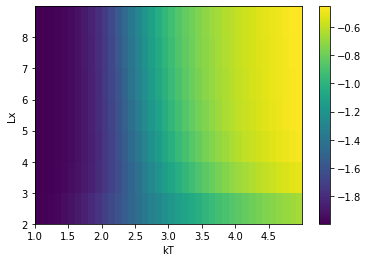

In [12]:
drawMap(8)